In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_approximation import Nystroem
import training_testing_LandPoleward40

all_models_trends_ , all_models_trend_maps_ = training_testing_LandPoleward40.training_testing()

# one climate model only has 9 valid simulations so throw it out
all_models_trends_ = np.delete(all_models_trends_, 9)
all_models_trend_maps_ = np.delete(all_models_trend_maps_, 9)
np.save('/home/disk/p/aodhan/SurfaceTrendLearing/DynamicForced/all_models_trends_LP40', all_models_trends_)
np.save('/home/disk/p/aodhan/SurfaceTrendLearing/DynamicForced/all_models_trend_maps_LP40', all_models_trend_maps_)

ACCESS_ESM1_5
CESM2
CanESM5
EC_Earth3
Could not find all files for simulation # 24
GISS_E2_1_G
GISS_E2_1_H
INM_CM5_0
IPSL_CM6A_LR
MIROC6
MPI_ESM1_2_HR
MPI_ESM1_2_LR
MRI_ESM2_0
NorCPM1


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


# PLS 

In [2]:
preds_val = []
for x in range(0, len(all_models_trends_)):
    # take all data besides along model index
    trends = np.delete(all_models_trends_, x)
    trends = np.concatenate(trends, axis=0)
    maps = np.delete(all_models_trend_maps_, x)
    maps = np.concatenate(maps, axis=0)

    # along model index we have loo data
    loo_trends = np.array(all_models_trends_[x])
    loo_maps = np.array(all_models_trend_maps_[x])

    # test on final timeperiod
    loo_trends_final = loo_trends[:,:,-1]
    loo_maps_final = loo_maps[:,:,-1]
    
    # Y-train
    total_trends_train = np.sum(trends, axis=1)[:,:,0]
    nat_nondyn_train = trends[:,0,:,1]
    nat_dyn_train = trends[:,0,:,2]
    for_nondyn_train = trends[:,1,:,1]
    for_dyn_train = trends[:,1,:,2]
    decomposed_trends = [nat_nondyn_train, nat_dyn_train, for_nondyn_train, for_dyn_train]
    decomposed_trends_shape = np.shape(decomposed_trends)
    decomposed_trends = np.reshape(decomposed_trends, (decomposed_trends_shape[0], decomposed_trends_shape[1]*decomposed_trends_shape[2]))
    Y_train = decomposed_trends.T

    # X-train
    maps = np.swapaxes(maps, 1, 2)
    maps = np.swapaxes(maps, 2, 3)
    maps = np.swapaxes(maps, 3, 4)
    maps_shape = np.shape(maps)
    X_train = np.reshape(maps, (maps_shape[0]*maps_shape[1], maps_shape[2], maps_shape[3], maps_shape[4]))
    total_nondynamic_train = np.sum([Y_train[:,0], Y_train[:,2]], axis=0)
    total_dynamic_train = np.sum([Y_train[:,1], Y_train[:,3]], axis=0)
    total_train = np.sum([total_nondynamic_train, total_dynamic_train], axis=0)
    sum_train = np.transpose([total_nondynamic_train, total_dynamic_train, total_train])
    
    # Y-test
    total_trends_test = np.sum(loo_trends_final, axis=1)[:,0]
    nat_nondyn_test = loo_trends_final[:,0,1]
    nat_dyn_test = loo_trends_final[:,0,2]
    for_nondyn_test = loo_trends_final[:,1,1]
    for_dyn_test = loo_trends_final[:,1,2]
    decomposed_trends_test = [nat_nondyn_test, nat_dyn_test, for_nondyn_test, for_dyn_test]
    Y_test = np.transpose(decomposed_trends_test)

    # X-test
    loo_maps_final = np.swapaxes(loo_maps_final, 1, 2)
    loo_maps_final = np.swapaxes(loo_maps_final, 2, 3)
    X_test = loo_maps_final
    total_nondynamic_test = np.sum([Y_test[:,0], Y_test[:,2]], axis=0)
    total_dynamic_test = np.sum([Y_test[:,1], Y_test[:,3]], axis=0)
    total_test = np.sum([total_nondynamic_test, total_dynamic_test], axis=0)
    sum_test = np.transpose([total_nondynamic_test, total_dynamic_test, total_test])


    ########################################################################################################
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
    X_train = np.concatenate((X_train, sum_train), axis=1)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))
    X_test = np.concatenate((X_test, sum_test), axis=1)


    # Apply the RBF kernel transformation to the X data and observations
    #kernel_feature = Nystroem(kernel='rbf', random_state=0)
    #X_train_transformed = kernel_feature.fit_transform(X_train)
    #X_test_transformed = kernel_feature.transform(X_test)
    ########################################################################################################

    pls = PLSRegression(n_components=7)
    pls.fit(X_train, Y_train)
    Y_preds = pls.predict(X_test)

    preds_val.append([Y_preds, Y_test])

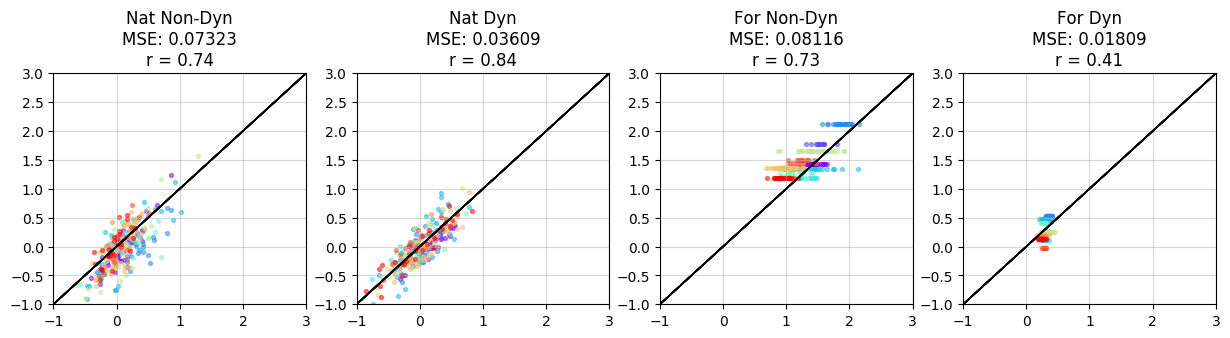

In [3]:
import matplotlib.cm as cm

fig, axs = plt.subplots(1,4, figsize=(15,3))
titles = ['Nat Non-Dyn', 'Nat Dyn', 'For Non-Dyn', 'For Dyn']
colors = cm.rainbow(np.linspace(0, 1, 12))
all_preds_val = np.concatenate(preds_val, axis=1)
all_preds_val = np.swapaxes(all_preds_val, 0,1)
for mod in range(0, len(preds_val)):
    Y_preds, Y_test = preds_val[mod]
    for x in range(4):
        axs[x].plot(np.linspace(-5,5), np.linspace(-5,5), linewidth=1, color='black')
        axs[x].scatter(x=Y_preds[:,x], y=Y_test[:,x], s=8, color=colors[mod], alpha=0.5)
        axs[x].set_xlim(-1,3)
        axs[x].set_ylim(-1,3)
        mse = np.mean(np.square(all_preds_val[:,0,x] - all_preds_val[:,1,x]))
        r = stats.pearsonr(all_preds_val[:,0,x], all_preds_val[:,1,x])[0]
        axs[x].set_title(titles[x] + '\n' + 'MSE: ' + str(mse)[:7] + '\n' + 'r = ' + str(r)[:4])
        axs[x].grid(alpha=0.5)


# Kernel-PLS

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
preds_val = []
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

for x in range(0, len(all_models_trends_)):
    # take all data besides along model index
    trends = np.delete(all_models_trends_, x)
    trends = np.concatenate(trends, axis=0)
    maps = np.delete(all_models_trend_maps_, x)
    maps = np.concatenate(maps, axis=0)

    # along model index we have loo data
    loo_trends = np.array(all_models_trends_[x])
    loo_maps = np.array(all_models_trend_maps_[x])

    # test on final timeperiod
    loo_trends_final = loo_trends[:,:,-1]
    loo_maps_final = loo_maps[:,:,-1]

    # X-train
    maps = np.swapaxes(maps, 1, 2)
    maps = np.swapaxes(maps, 2, 3)
    maps = np.swapaxes(maps, 3, 4)
    maps_shape = np.shape(maps)
    X_train = np.reshape(maps, (maps_shape[0]*maps_shape[1], maps_shape[2], maps_shape[3], maps_shape[4]))
    
    # Y-train
    total_trends_train = np.sum(trends, axis=1)[:,:,0]
    nat_nondyn_train = trends[:,0,:,1]
    nat_dyn_train = trends[:,0,:,2]
    for_nondyn_train = trends[:,1,:,1]
    for_dyn_train = trends[:,1,:,2]
    decomposed_trends = [nat_nondyn_train, nat_dyn_train, for_nondyn_train, for_dyn_train]
    decomposed_trends_shape = np.shape(decomposed_trends)
    decomposed_trends = np.reshape(decomposed_trends, (decomposed_trends_shape[0], decomposed_trends_shape[1]*decomposed_trends_shape[2]))
    Y_train = decomposed_trends.T
    

    # X-test
    loo_maps_final = np.swapaxes(loo_maps_final, 1, 2)
    loo_maps_final = np.swapaxes(loo_maps_final, 2, 3)
    X_test = loo_maps_final
    
    # Y-test
    total_trends_test = np.sum(loo_trends_final, axis=1)[:,0]
    nat_nondyn_test = loo_trends_final[:,0,1]
    nat_dyn_test = loo_trends_final[:,0,2]
    for_nondyn_test = loo_trends_final[:,1,1]
    for_dyn_test = loo_trends_final[:,1,2]
    decomposed_trends_test = [nat_nondyn_test, nat_dyn_test, for_nondyn_test, for_dyn_test]
    Y_test = np.transpose(decomposed_trends_test)
    
    # scale test and train data
    X_train_reshaped = np.reshape(X_train, (len(X_train), 72*144*2))
    X_test_reshaped = np.reshape(X_test, (len(X_test), 72*144*2))
    
    # (p)redictor scaling
    p = MinMaxScaler()
    p.fit(X_train_reshaped)
    X_train_scaled = p.transform(X_train_reshaped)
    #X_train_map = np.reshape(X_train_scaled, (len(X_train_scaled), 72,144,2))
    X_test_scaled = p.transform(X_test_reshaped)
    #X_test_map = np.reshape(X_test_scaled, (len(X_test_scaled), 72,144,2))

    # (t)arget scaling
    t = StandardScaler()
    t.fit(Y_train)
    Y_train_scaled = t.transform(Y_train)
    Y_test_scaled = t.transform(Y_test)

    # Apply the RBF kernel transformation to the X data and observations
    kernel_feature = Nystroem(kernel='rbf', random_state=0)
    X_train_transformed = kernel_feature.fit_transform(X_train_scaled)
    X_test_transformed = kernel_feature.transform(X_test_scaled)


    # evaluate the model
    pls = PLSRegression(n_components=11)
    pls.fit(X_train_transformed, Y_train_scaled)
    Y_preds_scaled = pls.predict(X_test_transformed)
    Y_preds = t.inverse_transform(Y_preds_scaled)

    preds_val.append([Y_preds, Y_test])
    mse = np.mean(np.square(Y_preds - Y_test), axis=0)

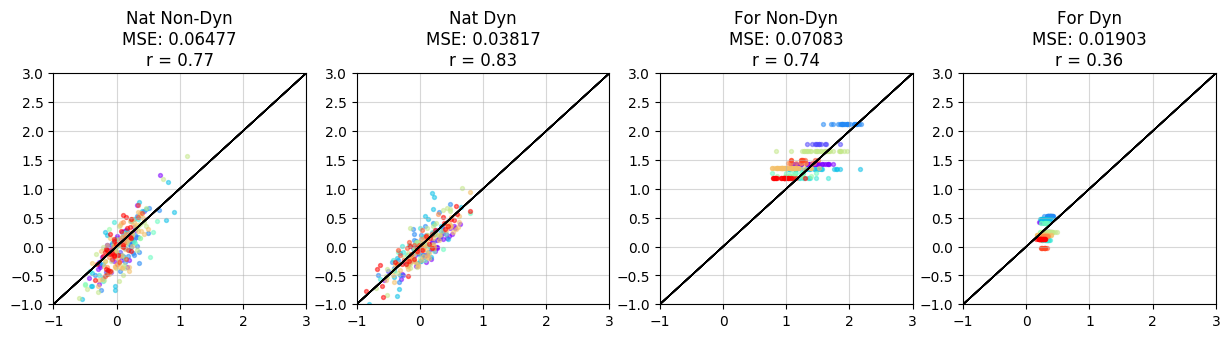

In [5]:
import matplotlib.cm as cm

fig, axs = plt.subplots(1,4, figsize=(15,3))
titles = ['Nat Non-Dyn', 'Nat Dyn', 'For Non-Dyn', 'For Dyn']
colors = cm.rainbow(np.linspace(0, 1, 12))
all_preds_val = np.concatenate(preds_val, axis=1)
all_preds_val = np.swapaxes(all_preds_val, 0,1)
for mod in range(0, len(preds_val)):
    Y_preds, Y_test = preds_val[mod]
    for x in range(4):
        axs[x].plot(np.linspace(-5,5), np.linspace(-5,5), linewidth=1, color='black')
        axs[x].scatter(x=Y_preds[:,x], y=Y_test[:,x], s=8, color=colors[mod], alpha=0.5)
        axs[x].set_xlim(-1,3)
        axs[x].set_ylim(-1,3)
        mse = np.mean(np.square(all_preds_val[:,0,x] - all_preds_val[:,1,x]))
        r = stats.pearsonr(all_preds_val[:,0,x], all_preds_val[:,1,x])[0]
        axs[x].set_title(titles[x] + '\n' + 'MSE: ' + str(mse)[:7] + '\n' + 'r = ' + str(r)[:4])
        axs[x].grid(alpha=0.5)


# PLS individual fits

In [33]:
preds_val = []
for x in range(0, len(all_models_trends_)):
    # take all data besides along model index
    trends = np.delete(all_models_trends_, x)
    trends = np.concatenate(trends, axis=0)
    maps = np.delete(all_models_trend_maps_, x)
    maps = np.concatenate(maps, axis=0)

    # along model index we have loo data
    loo_trends = np.array(all_models_trends_[x])
    loo_maps = np.array(all_models_trend_maps_[x])

    # test on final timeperiod
    loo_trends_final = loo_trends[:,:,-1]
    loo_maps_final = loo_maps[:,:,-1]
    
    # Y-train
    total_trends_train = np.sum(trends, axis=1)[:,:,0]
    nat_nondyn_train = trends[:,0,:,1]
    nat_dyn_train = trends[:,0,:,2]
    for_nondyn_train = trends[:,1,:,1]
    for_dyn_train = trends[:,1,:,2]
    decomposed_trends = [nat_nondyn_train, nat_dyn_train, for_nondyn_train, for_dyn_train]
    decomposed_trends_shape = np.shape(decomposed_trends)
    decomposed_trends = np.reshape(decomposed_trends, (decomposed_trends_shape[0], decomposed_trends_shape[1]*decomposed_trends_shape[2]))
    Y_train = decomposed_trends.T

    # X-train
    maps = np.swapaxes(maps, 1, 2)
    maps = np.swapaxes(maps, 2, 3)
    maps = np.swapaxes(maps, 3, 4)
    maps_shape = np.shape(maps)
    X_train = np.reshape(maps, (maps_shape[0]*maps_shape[1], maps_shape[2], maps_shape[3], maps_shape[4]))
    total_nondynamic_train = np.sum([Y_train[:,0], Y_train[:,2]], axis=0)
    total_dynamic_train = np.sum([Y_train[:,1], Y_train[:,3]], axis=0)
    total_train = np.sum([total_nondynamic_train, total_dynamic_train], axis=0)
    sum_train = np.transpose([total_nondynamic_train, total_dynamic_train, total_train])
    
    # Y-test
    total_trends_test = np.sum(loo_trends_final, axis=1)[:,0]
    nat_nondyn_test = loo_trends_final[:,0,1]
    nat_dyn_test = loo_trends_final[:,0,2]
    for_nondyn_test = loo_trends_final[:,1,1]
    for_dyn_test = loo_trends_final[:,1,2]
    decomposed_trends_test = [nat_nondyn_test, nat_dyn_test, for_nondyn_test, for_dyn_test]
    Y_test = np.transpose(decomposed_trends_test)

    # X-test
    loo_maps_final = np.swapaxes(loo_maps_final, 1, 2)
    loo_maps_final = np.swapaxes(loo_maps_final, 2, 3)
    X_test = loo_maps_final
    total_nondynamic_test = np.sum([Y_test[:,0], Y_test[:,2]], axis=0)
    total_dynamic_test = np.sum([Y_test[:,1], Y_test[:,3]], axis=0)
    total_test = np.sum([total_nondynamic_test, total_dynamic_test], axis=0)
    sum_test = np.transpose([total_nondynamic_test, total_dynamic_test, total_test])


    ########################################################################################################
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
    X_train = np.concatenate((X_train, sum_train), axis=1)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))
    X_test = np.concatenate((X_test, sum_test), axis=1)


    # Apply the RBF kernel transformation to the X data and observations
    #kernel_feature = Nystroem(kernel='rbf', random_state=0)
    #X_train_transformed = kernel_feature.fit_transform(X_train)
    #X_test_transformed = kernel_feature.transform(X_test)
    ########################################################################################################

    pls = PLSRegression(n_components=7)
    Y_preds = []
    for y in range(4):
        pls.fit(X_train, Y_train[:,y])
        Y_pred = pls.predict(X_test)
        Y_preds.append(Y_pred)
    Y_preds = np.transpose(Y_preds)
    preds_val.append([Y_preds, Y_test])

In [34]:
preds_val2 = []
for x in range(0, len(preds_val)):
    preds_val2.append([preds_val[x][0][0], preds_val[x][1]])


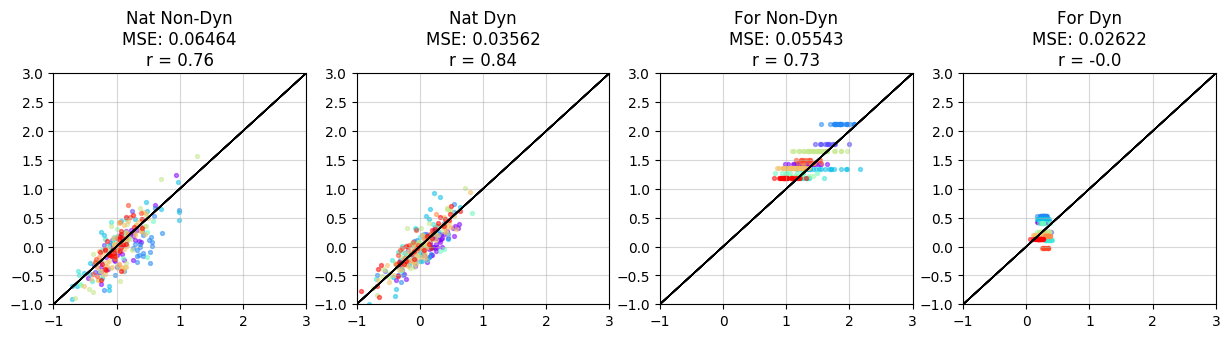

In [35]:
import matplotlib.cm as cm

fig, axs = plt.subplots(1,4, figsize=(15,3))
titles = ['Nat Non-Dyn', 'Nat Dyn', 'For Non-Dyn', 'For Dyn']
colors = cm.rainbow(np.linspace(0, 1, 12))
all_preds_val = np.concatenate(preds_val2, axis=1)
all_preds_val = np.swapaxes(all_preds_val, 0,1)
for mod in range(0, len(preds_val)):
    Y_preds, Y_test = preds_val2[mod]
    for x in range(4):
        axs[x].plot(np.linspace(-5,5), np.linspace(-5,5), linewidth=1, color='black')
        axs[x].scatter(x=Y_preds[:,x], y=Y_test[:,x], s=8, color=colors[mod], alpha=0.5)
        axs[x].set_xlim(-1,3)
        axs[x].set_ylim(-1,3)
        mse = np.mean(np.square(all_preds_val[:,0,x] - all_preds_val[:,1,x]))
        r = stats.pearsonr(all_preds_val[:,0,x], all_preds_val[:,1,x])[0]
        axs[x].set_title(titles[x] + '\n' + 'MSE: ' + str(mse)[:7] + '\n' + 'r = ' + str(r)[:4])
        axs[x].grid(alpha=0.5)